## Problem 1

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib as mpl

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

%pylab inline

def transitionMatrixG(G):
    """input G: a graph.
    output T: the transition matrix of G,
    column normalized.
    """
    A = nx.to_numpy_array(G)
    T = A.T / A.sum(axis=1)
    return T

def coreTransitionMatrixG(G):
    """Similar to transitionMatrixG but 
    Returns the core normalized transition matrix of G.
    The cloumns are normalized.
    """
    A = nx.to_numpy_array(G)
    coreness = nx.core_number(G)
    coreness = np.array([coreness[k] for k in range(len(coreness))])
    A = A * coreness
    T = A.T / A.sum(axis=1)
    #T.sum(axis=0)
    return T

def diffusionMatrix(T, alpha=0.2):
    """
    input T: a transition matrix (column normalized).
    input alpha: a the restart probability.
    Output K: the diffusion matrix, which is
    K = a [I - (1-a)T]^(-1)
    """
    n = T.shape[0]
    I = np.identity(n)
    K = I - (1 - alpha)*T
    K = alpha * np.linalg.inv(K)
    return K

def diffusionMatrixG(G, alpha=0.2, coreness=False):
    """
    input G: a networkz graph.
    input alpha: the restart parameter.
    input bool coreness: If True, the normalization uses core number rather
    than the standard adjacency matrix.
    Output K: the diffusion matrix, which is
    K = a [I - (1-a)T]^(-1)
    """
    #A = nx.to_numpy_array(G)
    #T = A.T / A.sum(axis=1)
    if coreness:
        T = coreTransitionMatrixG(G)
    else:
        T = transitionMatrixG(G)
    n = T.shape[0]
    I = np.identity(n)
    K = I - (1 - alpha)*T
    K = alpha * np.linalg.inv(K)
    return K


def RWR(T, alpha=0.2, q=1, epsilon=1e-6, maxiter=10**6):
    """Calculates the stationary distribution of a RWR process
    using the power method.
    input T: a transition matrix (column normalized).
    input alpha: restart probability.
    input q: restart distribution. If none is provided the uniform distribution
    is used (pageRank).
    input epsilon: the stop condition for the convergence.
    input maxiter: maximum number of iterations if convergence isn't reached.
    output p: the stationary distribution
    """
    n = T.shape[0]
    if q==1:
        q = 1/n * np.ones(n)
    x = q
    y = alpha * q + (1 - alpha) * np.dot(T, x)
    #while np.linalg.norm((x-y)) > epsilon:
    for _ in range(maxiter):
        x = y
        y = alpha * q + (1 - alpha) * np.dot(T, x)
        if np.linalg.norm((x-y)) < epsilon:
            break
    return y

def RWRG(G, alpha=0.2, q=1, epsilon=1e-6, maxiter=10**6):
    """Calculates the stationary distribution of a RWR process
    using the power method.
    input G: a networkx graph.
    input alpha: restart probability.
    input q: restart distribution. If none is provided the uniform distribution
    is used (pageRank).
    input epsilon: the stop condition for the convergence.
    input maxiter: maximum number of iterations if convergence isn't reached.
    output p: the stationary distribution
    outut c: vector with the difference between iterations (convergence)
    """
    A = nx.to_numpy_array(G)
    #T = A.T / A.sum(axis=1)
    s =  A.sum(axis=1)
    s = s + (s == 0) # flip 0s
    T = A.T / s
    n = T.shape[0]
    c = np.zeros(maxiter)
    if q==1:
        q = 1/n * np.ones(n)
    x = q
    y = alpha * q + (1 - alpha) * np.dot(T, x)
    #while np.linalg.norm((x-y)) > epsilon:
    for i in range(maxiter):
        x = y
        y = alpha * q + (1 - alpha) * np.dot(T, x)
        c[i] = np.linalg.norm((x-y))
        if  c[i] < epsilon:
            break
    return y,c

#rs = RandomState(MT19937(SeedSequence(42)))


Populating the interactive namespace from numpy and matplotlib


In [25]:
G1 = nx.erdos_renyi_graph(n=100, p=0.01, seed=42)
y,c = RWRG(G1, alpha=0.15, q=1)
q = np.ones(100)/100

In [23]:
y.sum()

0.6939999999999998

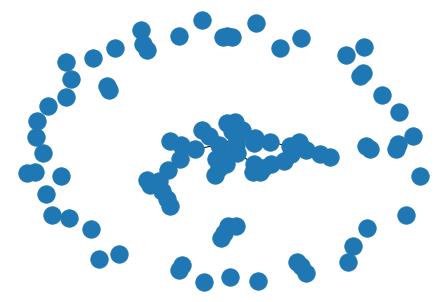

In [24]:
nx.draw_spring(G1)

The graph is not connected and some of the vertices have $0$ edges. Therefore this graph is not stochastic because a vertex without edges doesn't have a transition distribution.
So we can't really talk about pageRank of this graph.

In [13]:
T = np.nan_to_num(A / A.sum(axis=0))
T.sum()

<ipython-input-13-ea3117739772>:1: RuntimeWarning: invalid value encountered in true_divide
  T = np.nan_to_num(A / A.sum(axis=0))


63.99999999999999

In [27]:
G2 = nx.erdos_renyi_graph(n=100, p=0.08, seed=42)
y,c = RWRG(G2, alpha=0.15, q=1)
q = np.ones(100)/100
y.sum()

0.9999999999999997

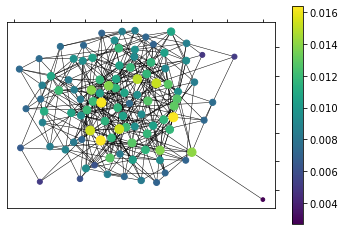

In [87]:
#nx.draw_spring(G2, node_size=y*5000, node_color=y, cmap=plt.cm.viridis  )
#plt.colorbar?
#ax = plt.subplot()
#im = nx.draw_spring(G2, node_size=y*5000, node_color=y, cmap=plt.cm.viridis  )
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#plt.colorbar(im)
plt.imshow(y.reshape((10,10)))
plt.colorbar()
plt.cla()
pos = nx.layout.spring_layout(G2)
nodes = nx.draw_networkx_nodes(G2, pos, node_size=5000*y, node_color=y, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G2,pos,width=0.5)
#pc = mpl.collections.PatchCollection(nodes, cmap=plt.cm.viridis)
#pc = mpl.collections.PatchCollection(y, cmap=plt.cm.viridis)
#pc.set_array(edge_colors)
#plt.colorbar(pc)
#plt.colorbar(nodes)
#plt.colorbar()
### Don't know how to draw this damn color bar :()

#ax = plt.gca()
#ax.set_axis_off()
#plt.show()

In [31]:
K = diffusionMatrixG(G2, alpha=0.15)
p = np.dot(K,q)
np.linalg.norm(y-p) # we see that both methods give very similar result


3.7494711606640593e-07

In [33]:
numIters = (c > 0).sum()
numIters

15

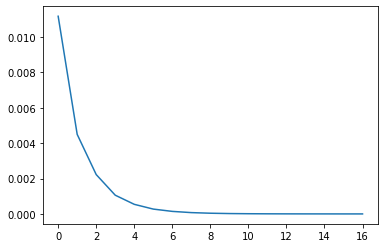

In [34]:
plt.plot(np.arange(17),c[:17])

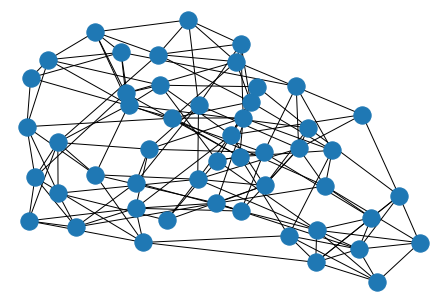

In [35]:
G4 = nx.watts_strogatz_graph(n=50, k=7, p=0.3)
q = np.ones(50)/50
nx.draw_spring(G4)

In [36]:
y,c = RWRG(G2, alpha=0.15, q=1)
q = np.ones(100)/100
y.sum()

0.9999999999999997

In [37]:
K = diffusionMatrixG(G2, alpha=0.15)
p = np.dot(K,q)
np.linalg.norm(y-p) # we see that both methods give very similar result

3.7494711606640593e-07

15


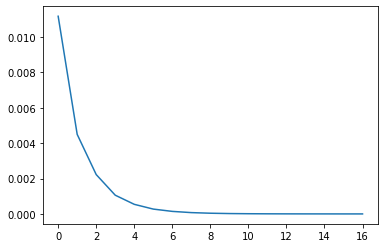

In [39]:
numIters = (c > 0).sum()
print(numIters)
plt.plot(np.arange(numIters+2),c[:numIters+2])

### Part E 
$p_0$ doesn't change the result, becaue $E \cdot v = (1/n,\dots,1/n)$ for any distribution vector, where $E$ is the matrix with all entries equal $1/n$.